In [1]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *

In [2]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

KeyboardInterrupt: 

## Looking at performance

In [56]:
for date in dates[:20]:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )

[array([[69, 79]], dtype=uint8) array([], shape=(0, 0), dtype=uint8)
 array([[nan, nan]]) array([[79, 81]], dtype=uint8)
 array([[-67,  68,  91, 118, 141, 194]], dtype=int16)
 array([[ 77,  79, 104, 114, 123, 149]], dtype=uint8)
 array([], shape=(0, 0), dtype=uint8)
 array([[ 62,  80,  95, 105, 136, 157]], dtype=uint8)
 array([[nan, nan, nan, nan, nan]])
 array([[ 75, 158, 163, 207]], dtype=uint8)
 array([[ 73, 111, 154]], dtype=uint8)
 array([[76, 78, 83, 98]], dtype=uint8)
 array([[ 72,  76,  84, 141, 150]], dtype=uint8)
 array([], shape=(0, 0), dtype=uint8) array([], shape=(0, 0), dtype=uint8)
 array([[nan, nan, nan, nan, nan]]) array([], shape=(0, 0), dtype=uint8)
 array([[ 70,  89, 112, 114, 132, 136, 138, 165, 182]], dtype=uint8)
 array([], shape=(0, 0), dtype=uint8)
 array([[ 76, 118, 146, 148]], dtype=uint8)
 array([], shape=(0, 0), dtype=uint8) array([[nan, nan, nan]])
 array([[ 71,  80,  96, 130, 152]], dtype=uint8)
 array([], shape=(0, 0), dtype=uint8) array([[nan, nan, nan]

[array([[72, 74, 76]], dtype=uint8) array([[ 72, 107]], dtype=uint8)
 array([[ 68,  71,  76, 195, 198, 218]], dtype=uint8)
 array([[73]], dtype=uint8)
 array([[ 72,  78,  81,  87,  97, 108, 129, 201]], dtype=uint8)
 array([[ 73,  76,  83, 187, 190, 207, 213]], dtype=uint8)
 array([[74]], dtype=uint8) array([[-155,   74,  151]], dtype=int16)
 array([[-241, -219,  -84,    1,   17,   73,   74,   78,   96,  165]],
      dtype=int16)
 array([[-277]], dtype=int16)
 array([[-174,  -88,  -60,   -6,   48,   69,  172,  189]], dtype=int16)
 array([[-54, -15, -13,   1,  68,  87,  94, 105, 113, 117, 122, 127, 129,
        150, 180]], dtype=int16)
 array([[ 72,  79,  90, 109]], dtype=uint8)
 array([[-153,  -99,  -72,   84,   99,  107,  132,  144]], dtype=int16)
 array([[ 82,  83,  84,  86,  94,  97, 114, 116, 117, 187, 188, 204, 206]],
      dtype=uint8)
 array([[-509, -485,  -91,   22,   34,   36,   42,   46,   79,   80,   84,
         114,  133,  156]], dtype=int16)
 array([[-76, -74, -70, -66, -6

[array([[-21,   2,  52,  60,  69,  73,  78,  89,  90, 127, 147, 161, 200,
        206]], dtype=int16)
 array([[-247,   49,   60,   75,  108,  117]], dtype=int16)
 array([[-95,  80, 118, 126, 131, 191]], dtype=int16)
 array([[ 79, 100, 126, 131, 140, 170, 174]], dtype=uint8)
 array([[-256, -134,   24,   27,   48,   55,   60,   65,   67,   81,   90]],
      dtype=int16)
 array([[-152, -144,   69,   78]], dtype=int16)
 array([[-136, -135, -130]], dtype=int16)
 array([[ 71,  81, 143, 163, 174]], dtype=uint8)
 array([[59, 66]], dtype=uint8) array([[ 74, 139]], dtype=uint8)
 array([[ 82, 186]], dtype=uint8)
 array([[-441,  -32,  -31,   71,   76,  118,  122]], dtype=int16)
 array([[ 59,  66,  75,  81, 144]], dtype=uint8)
 array([[66, 70]], dtype=uint8)
 array([[ 39,  57,  71,  96, 131, 149]], dtype=uint8)
 array([[-397, -393, -390, -319, -314, -311,   64,   75]], dtype=int16)
 array([[ 51,  74,  96, 103, 191]], dtype=uint8)
 array([[ 69,  80, 138, 139, 141]], dtype=uint8)
 array([[ 81, 108, 1

[array([[20, 40, 68, 76]], dtype=uint8)
 array([[ 76,  85, 132, 134, 139]], dtype=uint8)
 array([[ 35,  64,  73,  78,  82, 120, 130]], dtype=uint8)
 array([[-28,  62,  71]], dtype=int16) array([[-63,  81]], dtype=int16)
 array([[75]], dtype=uint8) array([[-154,  -71]], dtype=int16)
 array([[78]], dtype=uint8) array([[71, 78]], dtype=uint8)
 array([[ 61,  69, 191]], dtype=uint8)
 array([[ 65,  69,  73, 138, 145, 185]], dtype=uint8)
 array([[-42,  73,  74,  80, 124, 126, 137]], dtype=int16)
 array([[-160, -154, -149,   48,   56,   60,   66,   70,   74,   78,   94,
         124,  125,  126,  150,  162]], dtype=int16)
 array([[ 60,  73, 155, 161, 188]], dtype=uint8)
 array([[-581, -579, -576, -538, -531, -527, -523, -517, -511, -293, -192,
        -165,   26,   35,   64,   72,   78,   89,   90,  106,  139]],
      dtype=int16)
 array([[-529,  102,  117,  123]], dtype=int16)
 array([[70, 78]], dtype=uint8) array([[68]], dtype=uint8)
 array([[ 69, 181]], dtype=uint8) array([[-5,  1, 76]], dt

[array([[68]], dtype=uint8) array([[ 62,  74,  99, 116]], dtype=uint8)
 array([[-104,  -90,   73,  122]], dtype=int16)
 array([[66, 80]], dtype=uint8)
 array([[11, 12, 37, 43, 73, 78]], dtype=uint8)
 array([[56, 57, 58, 64, 69]], dtype=uint8)
 array([[-183, -182, -180, -160, -155, -150, -139, -134, -124,   67,   75]],
      dtype=int16)
 array([[-1108, -1104,  -533,  -522,    86]], dtype=int16)
 array([[69, 73, 86, 95, 99]], dtype=uint8) array([[74, 80]], dtype=uint8)
 array([[75, 82]], dtype=uint8) array([[72]], dtype=uint8)
 array([[48, 70, 73, 82]], dtype=uint8)
 array([[ 11,  13,  27,  29,  69,  74, 112, 117, 122, 135, 136]],
      dtype=uint8)
 array([[79]], dtype=uint8)
 array([[-10,  11,  13,  24,  25,  28,  32,  57,  59,  65,  66,  73,  74]],
      dtype=int16)
 array([[ 71, 156, 157, 170, 182]], dtype=uint8)
 array([[38, 50, 61, 65, 73, 82]], dtype=uint8)
 array([[-66, -59, -58,  74,  77,  81,  97,  98, 187]], dtype=int16)
 array([[ -2,  23,  69,  72, 106, 112]], dtype=int16)


[array([[-19, -16,  -5,  -2,   5,  10,  16,  23,  57,  73,  79, 110, 133,
        137, 147, 201]], dtype=int16)
 array([[ -7,  -3,   1,  77, 136]], dtype=int16)
 array([[55, 61, 70]], dtype=uint8)
 array([[ 74,  81, 104, 162]], dtype=uint8)
 array([[ 72, 150]], dtype=uint8)
 array([[ 39,  43,  44,  51,  54,  56,  59,  64,  70,  76, 137]],
      dtype=uint8)
 array([[71]], dtype=uint8)
 array([[-14,  -6,  -2,   4,  69]], dtype=int16)
 array([[ 70, 181, 184]], dtype=uint8) array([[62, 72]], dtype=uint8)
 array([[ 69, 156]], dtype=uint8)
 array([[ 66,  73, 118, 120, 170]], dtype=uint8)
 array([[ 70, 132, 136, 141]], dtype=uint8)
 array([[ 70, 135]], dtype=uint8)
 array([[ 73,  79, 118, 125]], dtype=uint8) array([[75]], dtype=uint8)
 array([[ 75, 155]], dtype=uint8)
 array([[ 64,  71,  76, 115, 117]], dtype=uint8)
 array([[ 82, 116, 124]], dtype=uint8)
 array([[ 68, 106, 112, 116]], dtype=uint8)
 array([[53, 58, 63, 71, 78]], dtype=uint8)
 array([[ 57,  82,  87, 105, 106, 122, 133]], dtype

[array([[ 8, 11, 50, 72]], dtype=uint8)
 array([[-10,  -6,  -3,  70]], dtype=int16) array([[69]], dtype=uint8)
 array([[ 74, 164]], dtype=uint8) array([[-4, -1,  2, 77]], dtype=int16)
 array([[ 10,  13,  74, 147, 198]], dtype=uint8)
 array([[ 36,  39,  49,  58,  60,  71, 149]], dtype=uint8)
 array([[  6,  11,  17,  31,  50,  56,  64,  70,  74,  78, 122, 124]],
      dtype=uint8)
 array([[-655, -652, -605, -602, -596, -576, -571,  -69,   84,   94,  142,
         142]], dtype=int16)
 array([[71]], dtype=uint8)
 array([[-10,  -8,  57,  61,  75,  82]], dtype=int16)
 array([[ -7,  73, 137]], dtype=int16) array([[-8, 69]], dtype=int16)
 array([[66, 72]], dtype=uint8)
 array([[ 26,  32,  38,  41,  51,  56,  63,  68, 200]], dtype=uint8)
 array([[79]], dtype=uint8) array([[-3, -2,  0,  3,  6, 73]], dtype=int16)
 array([[68, 74]], dtype=uint8)
 array([[ 42,  44,  44,  46,  47,  61,  64,  70,  90, 130, 132, 136]],
      dtype=uint8)
 array([[-2, 24, 72]], dtype=int16) array([[14, 70]], dtype=uint

[array([[ 78, 134, 140]], dtype=uint8) array([[ 74, 176]], dtype=uint8)
 array([[72]], dtype=uint8) array([[81]], dtype=uint8)
 array([[75]], dtype=uint8) array([[ 6,  7, 12, 73]], dtype=uint8)
 array([[80]], dtype=uint8) array([[78]], dtype=uint8)
 array([[80]], dtype=uint8) array([[71]], dtype=uint8)
 array([[ 57,  75,  86, 180, 186]], dtype=uint8)
 array([[81]], dtype=uint8) array([[80]], dtype=uint8)
 array([[82]], dtype=uint8)
 array([[-16, -12,  28,  31,  33,  75]], dtype=int16)
 array([[69]], dtype=uint8) array([[69]], dtype=uint8)
 array([[63, 65, 69, 75]], dtype=uint8) array([[77]], dtype=uint8)
 array([[74]], dtype=uint8) array([[-9,  9, 73]], dtype=int16)
 array([[ 82, 178]], dtype=uint8) array([[72]], dtype=uint8)
 array([[18, 20, 21, 39, 61]], dtype=uint8) array([[74, 78]], dtype=uint8)
 array([[72, 78, 81]], dtype=uint8) array([[-1, 82]], dtype=int16)
 array([[-16,  75]], dtype=int16)
 array([[ 72, 161, 168, 171]], dtype=uint8) array([[73]], dtype=uint8)
 array([[ 69, 151

[array([[70]], dtype=uint8) array([[74]], dtype=uint8)
 array([[72]], dtype=uint8) array([[80]], dtype=uint8)
 array([[-508, -504, -492, -491, -491, -490, -464,   62,   68,   75,   87,
          88,  121,  121,  122]], dtype=int16)
 array([[15, 25, 52, 55, 61, 66, 70, 74]], dtype=uint8)
 array([[-55, -42, -32, -24,  48,  57,  61,  66,  71,  75, 109, 111]],
      dtype=int16)
 array([[56, 77]], dtype=uint8)
 array([[ 42,  43,  46,  78, 169, 172, 174, 179, 183]], dtype=uint8)
 array([[73]], dtype=uint8)
 array([[ 63,  65,  70,  74, 122, 123, 126]], dtype=uint8)
 array([[ 77, 126]], dtype=uint8)
 array([[-35,  42,  45,  59,  64,  72,  77, 103, 157, 172]], dtype=int16)
 array([[71, 77]], dtype=uint8)
 array([[ 75, 110, 133, 134, 136, 142, 146, 174]], dtype=uint8)
 array([[-470, -467, -466, -464, -460, -456, -450, -448, -431, -427, -424,
        -419, -379, -377, -372, -369,   11,   20,   23,   32,   33,   49,
          51,   64,   69,   79,   97,   97,  106,  125,  142,  145]],
      dtype

[array([[ 37,  48,  59,  65,  69, 161, 177, 181, 183]], dtype=uint8)
 array([[-171, -166, -162,    2,    4,   21,   30,   48,   49,   54,   67,
          73,   79,  110]], dtype=int16)
 array([[-16, -10,  65, 125, 127, 129, 133, 145, 150]], dtype=int16)
 array([[-1543, -1535, -1521, -1519, -1518, -1515, -1505, -1504, -1490,
        -1489, -1458, -1088, -1084, -1070, -1068, -1065, -1059, -1053,
        -1048, -1043, -1041, -1039, -1016, -1007, -1005,  -739,  -736,
         -733,  -731,  -729,  -719,  -717,  -714,  -708,  -702,  -654,
         -649,  -647,  -628,  -623,  -611,  -596,  -593,  -592,  -591,
         -586,  -316,  -311,  -303,  -284,  -265,  -259,  -254,   -58,
          -53,   -50,   -42,    37,    49,    68]], dtype=int16)
 array([[-482, -481, -477, -474, -466, -450, -227, -224, -218, -212, -208,
        -199, -197, -197, -168, -161, -155, -140, -134, -133, -128,    3,
           9,   19,   26,   75,  125]], dtype=int16)
 array([[-130,   30,   46,   50,   69,   95,  103,  

[array([[29, 31, 33, 37, 78]], dtype=uint8) array([[78]], dtype=uint8)
 array([[71]], dtype=uint8)
 array([[-12,  -7,  80, 127, 129, 136, 142, 151]], dtype=int16)
 array([[-260, -257, -254, -180,   46,   53,   58,   70,   95,   96,  101]],
      dtype=int16)
 array([[68]], dtype=uint8) array([[70]], dtype=uint8)
 array([[ 68, 128, 142, 146]], dtype=uint8) array([[71]], dtype=uint8)
 array([[ 78, 121, 124, 128]], dtype=uint8)
 array([[ 70, 166]], dtype=uint8) array([[81]], dtype=uint8)
 array([[76]], dtype=uint8) array([[70]], dtype=uint8)
 array([[ 72, 123, 126]], dtype=uint8) array([[ 75, 128]], dtype=uint8)
 array([[73]], dtype=uint8) array([[68]], dtype=uint8)
 array([[ 74, 134, 137]], dtype=uint8) array([[73]], dtype=uint8)
 array([[-254,   64,   69,   85,   86,  133]], dtype=int16)
 array([[78]], dtype=uint8)
 array([[-774, -771, -768, -766, -763, -693, -319, -309, -288,   33,   43,
          52,   61,   70,  113,  129,  133]], dtype=int16)
 array([[81]], dtype=uint8)
 array([[ 55

[array([[ 9, 12, 29, 29, 39, 47, 51, 53, 75]], dtype=uint8)
 array([[ 71,  80, 144, 174, 176]], dtype=uint8)
 array([[ 69, 133, 136, 145]], dtype=uint8) array([[75]], dtype=uint8)
 array([[ 79, 123, 126]], dtype=uint8) array([[79]], dtype=uint8)
 array([[ 65,  75,  79, 127, 130]], dtype=uint8)
 array([[69]], dtype=uint8) array([[ 75, 142, 145]], dtype=uint8)
 array([[ 76, 138, 140]], dtype=uint8) array([[71]], dtype=uint8)
 array([[ 49,  55,  59,  62,  69, 129, 148, 149]], dtype=uint8)
 array([[76]], dtype=uint8) array([[73]], dtype=uint8)
 array([[69, 78]], dtype=uint8) array([[ 66,  74, 143]], dtype=uint8)
 array([[ 74,  82, 129, 148]], dtype=uint8)
 array([[ 77, 135]], dtype=uint8)
 array([[ 56,  63,  73,  77, 126, 128, 133, 136, 139]], dtype=uint8)
 array([[ 63,  70,  74,  81, 134]], dtype=uint8)
 array([[ 80,  90,  92,  93,  95, 108, 110, 112, 114, 118, 125]],
      dtype=uint8)
 array([[ 77, 116, 117, 122]], dtype=uint8)
 array([[ 81, 127]], dtype=uint8) array([[ 70, 121]], dtype

[array([[-78, -60, -57, -39, -37,  37,  42,  48,  52,  58,  65,  71]],
      dtype=int16)
 array([[ 79, 140, 144]], dtype=uint8)
 array([[ 73, 103, 106, 110, 111, 115, 116, 144, 151, 154]], dtype=uint8)
 array([[-1,  2, 40, 48, 54, 59, 66, 77, 80]], dtype=int16)
 array([[ 42,  52,  59,  64,  68, 196]], dtype=uint8)
 array([[70]], dtype=uint8)
 array([[-189, -188, -177, -175,   63,  103,  140,  144]], dtype=int16)
 array([[-10,  -6,  -4,   8,  19,  20,  25,  27,  31,  37,  39,  72, 142,
        146, 147]], dtype=int16)
 array([[-170,   19,   23,   27,   34,   42]], dtype=int16)
 array([[ -8,  19,  34,  36,  72, 141, 142]], dtype=int16)
 array([[  4,  30,  30,  34,  79, 144, 147]], dtype=uint8)
 array([[-29, -27, -22, -14,   4,  70,  78, 128, 129, 132, 139]],
      dtype=int16)
 array([[ 79, 140]], dtype=uint8)
 array([[17, 19, 21, 23, 26, 80]], dtype=uint8)
 array([[  4,   5,   7,  10,  12,  15,  76, 106]], dtype=uint8)
 array([[-16, -14, -12,   9,  12,  25,  42,  45,  65,  73]], dtype=

[array([[76, 81]], dtype=uint8) array([[ 1,  3, 81]], dtype=uint8)
 array([[71]], dtype=uint8)
 array([[-38, -36, -23, -22, -21,  60,  69, 102, 105, 107, 110]],
      dtype=int16)
 array([[-279,   75,   97,  105,  107,  109]], dtype=int16)
 array([[71, 84, 85, 87]], dtype=uint8) array([[25, 26, 73]], dtype=uint8)
 array([[81]], dtype=uint8) array([[47, 49, 52, 77]], dtype=uint8)
 array([[-23,  75]], dtype=int16) array([[80]], dtype=uint8)
 array([[ 52,  74,  82,  91, 120, 124]], dtype=uint8)
 array([[70, 79]], dtype=uint8) array([[75]], dtype=uint8)
 array([[ 64,  72, 120]], dtype=uint8)
 array([[-24, 126, 128, 132]], dtype=int16)
 array([[ 17, 108, 110, 120, 121, 123]], dtype=uint8)
 array([[69, 81, 83]], dtype=uint8)
 array([[ 73, 114, 115, 142]], dtype=uint8) array([[78]], dtype=uint8)
 array([[ 65,  71, 140, 142, 143]], dtype=uint8)
 array([[ 71,  78, 125, 126, 128, 133, 137]], dtype=uint8)
 array([[50, 60, 67, 71, 75]], dtype=uint8) array([[72]], dtype=uint8)
 array([[ 77, 124, 12

[array([[  0,  35,  38,  66,  78, 126]], dtype=uint8)
 array([[65, 69, 73]], dtype=uint8)
 array([[ 52,  59,  68, 152]], dtype=uint8) array([[73, 81]], dtype=uint8)
 array([[ 11,  12,  79,  97, 117, 119]], dtype=uint8)
 array([[ 73,  81, 114]], dtype=uint8)
 array([[ 64,  73,  77, 122]], dtype=uint8)
 array([[ 66,  72, 118]], dtype=uint8) array([[68]], dtype=uint8)
 array([[ 63,  69, 126]], dtype=uint8)
 array([[-20,  38,  81,  97, 107, 110]], dtype=int16)
 array([[ 69,  70,  83, 188]], dtype=uint8)
 array([[ 77, 142]], dtype=uint8) array([[62, 67, 71, 98]], dtype=uint8)
 array([[ 67,  77, 117]], dtype=uint8)
 array([[ 75, 114, 116]], dtype=uint8) array([[69]], dtype=uint8)
 array([[ 73, 128]], dtype=uint8) array([[ 68, 146]], dtype=uint8)
 array([[ 82, 133, 137]], dtype=uint8)
 array([[ 61,  67, 112]], dtype=uint8) array([[ 69, 115]], dtype=uint8)
 array([[ 69,  78, 115, 119, 123]], dtype=uint8)
 array([[81]], dtype=uint8) array([[62, 65, 69]], dtype=uint8)
 array([[ 59,  69, 135, 137

[array([[-12,  -3,  31,  70,  77, 112]], dtype=int16)
 array([[73]], dtype=uint8) array([[75]], dtype=uint8)
 array([[-11,  12,  13,  16,  21,  55,  62,  68,  72]], dtype=int16)
 array([[31, 32, 72]], dtype=uint8) array([[59, 64, 71, 78]], dtype=uint8)
 array([[73]], dtype=uint8) array([[77]], dtype=uint8)
 array([[74, 81]], dtype=uint8) array([[ 73, 132]], dtype=uint8)
 array([[ 79, 127, 133]], dtype=uint8) array([[ 68, 135]], dtype=uint8)
 array([[ 38,  68, 122, 134]], dtype=uint8)
 array([[ 66,  69, 105, 106, 108, 111]], dtype=uint8)
 array([[ 67, 117, 121, 123, 142, 143]], dtype=uint8)
 array([[ 74, 128, 130, 144]], dtype=uint8) array([[70, 80]], dtype=uint8)
 array([[ 69, 121]], dtype=uint8)
 array([[ 63,  70,  77, 110]], dtype=uint8)
 array([[ 56,  63,  71,  76, 150]], dtype=uint8)
 array([[80]], dtype=uint8) array([[82]], dtype=uint8)
 array([[ 74,  91, 129, 145]], dtype=uint8)
 array([[ 74,  78, 139, 141, 143]], dtype=uint8)
 array([[69, 76]], dtype=uint8) array([[79]], dtype=u

Text(0.5, 1.0, 'Learning Data Mouse mSM63')

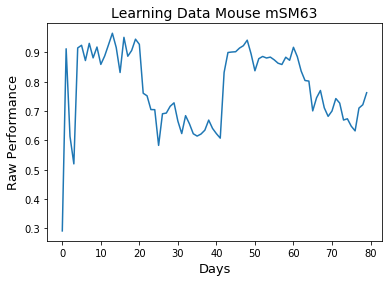

In [13]:
# Collects accuracy values
raw_accuracy = []
aud_accuracy = []
p_aud = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    is_aud_trial = np.array(session.is_aud_trial)
    indices = np.argwhere(is_aud_trial)
    p_aud.append(
        np.sum(session.is_aud_trial)/len(session.is_aud_trial)
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    raw_accuracy.append(
        np.sum(expected == actual)/(1.0*expected.size)
        )
    aud_expected = expected[indices]
    aud_actual = actual[indices]
    aud_accuracy.append(
        np.sum(aud_expected == aud_actual)/(1.0*aud_expected.size)
        )
plt.plot(raw_accuracy)
plt.ylabel("Raw Performance", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)

Text(0.5, 1.0, 'Learning Data Mouse mSM63')

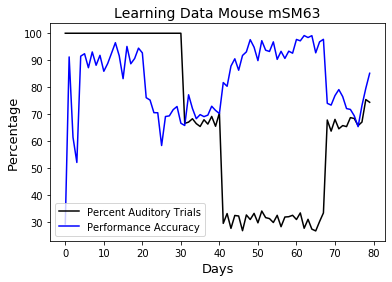

In [14]:
# Plots auditory-only accuracy
p_aud = np.array(p_aud)
aud_accuracy = np.array(aud_accuracy)
plt.plot(p_aud*100, color="black", label="Percent Auditory Trials")
plt.plot(aud_accuracy*100, color="blue", label="Performance Accuracy")
plt.ylabel("Percentage", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.legend()
plt.title("Learning Data Mouse mSM63", fontsize=14)

Text(0.5, 1.0, 'Learning Data Mouse mSM63')

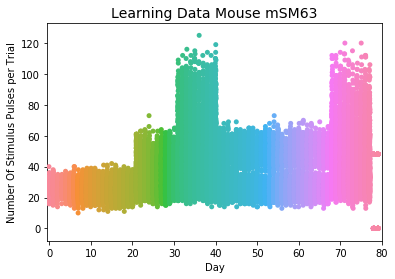

In [15]:
# Collects accuracy values
import pandas as pd
import seaborn as sns
num_stims = []
days = []
for date_idx, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    num_trials = session.trialmarkers['CorrectSide'].size
    for i in range(num_trials):
        ns = session.trialmarkers['tacStimL'][i].size + \
            session.trialmarkers['tacStimR'][i].size + \
            session.trialmarkers['audStimL'][i].size + \
            session.trialmarkers['audStimR'][i].size
        num_stims.append(ns)
        days.append(date_idx)
df = pd.DataFrame({
    'Number Of Stimulus Pulses per Trial': num_stims,
    'Day': days
    })
sns.stripplot(
    x='Day', y='Number Of Stimulus Pulses per Trial',
    data=df
    )
plt.xticks(np.arange(0,90,10),np.arange(0,90,10))
plt.title("Learning Data Mouse mSM63", fontsize=14)

## Looking at simple info

What is the proportion of auditory left/right as defined by experiment?

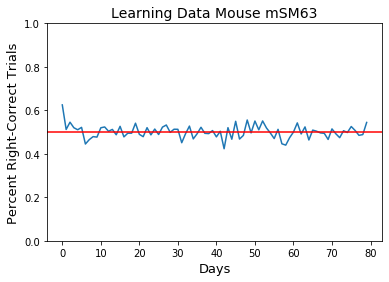

In [16]:
# Plots percent right
p_right = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    is_aud_trial = np.array(session.is_aud_trial)
    indices = np.argwhere(is_aud_trial)
    expected = np.array(
        session.trialmarkers['CorrectSide'][indices]
        )
    p_right.append(np.sum(expected == 2)*1.0/expected.size)
fig, ax = plt.subplots()
plt.plot(p_right)
plt.ylabel("Percent Right-Correct Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0,1.0))
ax.axhline(0.5, color='red')
plt.show()

What is the proportion of left/right that the mouse chooses in auditory trials?

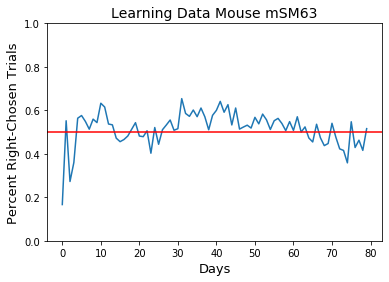

In [17]:
# Plots percent right
p_right_chosen = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    is_aud_trial = np.array(session.is_aud_trial)
    indices = np.argwhere(is_aud_trial)
    expected = np.array(
        session.trialmarkers['ResponseSide'][indices]
        )
    p_right_chosen.append(
        np.sum(expected == 2)*1.0/expected.size
        )
fig, ax = plt.subplots()
ax.plot(p_right_chosen)
plt.ylabel("Percent Right-Chosen Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0.0,1.0))
ax.axhline(0.5, color="red")
plt.show()

Looking at choice transitions from previous trial to current trial

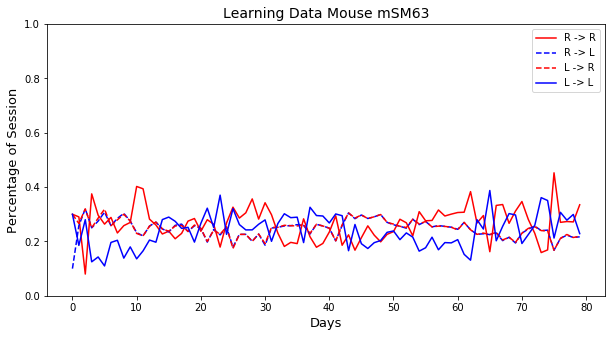

In [28]:
# Plots percent right
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    actual = np.array(session.trialmarkers['ResponseSide'])
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    for idx in np.arange(1, actual.size):
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                counter += 1
    right_to_right.append(r_to_r/(counter*1.0))
    right_to_left.append(r_to_l/(counter*1.0))
    left_to_left.append(l_to_l/(counter*1.0))
    left_to_right.append(l_to_r/(counter*1.0))
    date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Session", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.legend()
plt.ylim((0,1))
plt.show()

Looking at choice transitions from previous trial to current trial, for only incorrect trials

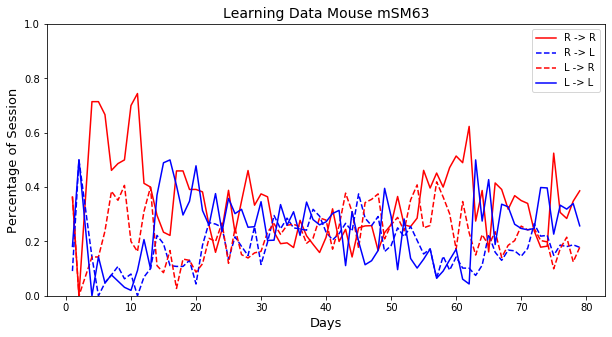

In [29]:
# Plot
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    for idx in incorrect_trials:
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                counter += 1
    if counter > 0:
        right_to_right.append(r_to_r/(counter*1.0))
        right_to_left.append(r_to_l/(counter*1.0))
        left_to_left.append(l_to_l/(counter*1.0))
        left_to_right.append(l_to_r/(counter*1.0))
        date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Session", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.legend()
plt.ylim((0,1))
plt.show()

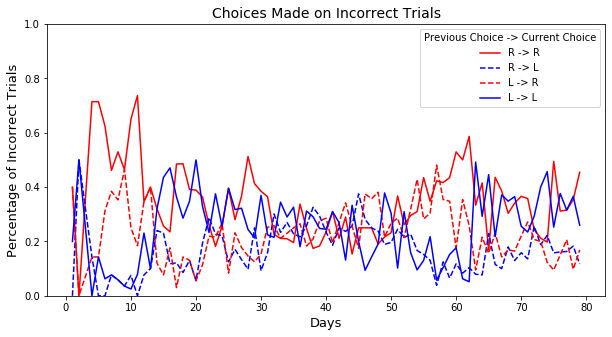

In [6]:
# Plot
right_to_right = []
right_to_left = []
left_to_left = []
left_to_right = []
date_nums = []
counters = []
for date_num, date in enumerate(dates):
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    counter = 0
    r_to_r = 0
    r_to_l = 0
    l_to_l = 0
    l_to_r = 0
    total_rs = 0
    total_ls = 0
    for idx in incorrect_trials:
        if expected[idx - 1] != actual[idx - 1]:
            continue
        if actual[idx - 1] == 1: # Left
            if actual[idx] == 1: # To Left
                l_to_l += 1
                total_ls += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                l_to_r += 1
                total_rs += 1
                counter += 1
        elif actual[idx - 1] == 2: # Right
            if actual[idx] == 1: # To Left
                r_to_l += 1
                total_ls += 1
                counter += 1
            elif actual[idx] == 2: # To Right
                r_to_r += 1
                total_rs += 1
                counter += 1
    counters.append(counter)
    if counter > 0:
        right_to_right.append(r_to_r/(counter*1.0))
        right_to_left.append(r_to_l/(counter*1.0))
        left_to_left.append(l_to_l/(counter*1.0))
        left_to_right.append(l_to_r/(counter*1.0))
        date_nums.append(date_num)
plt.figure(figsize=(10,5))
plt.plot(date_nums, right_to_right, "r-", label="R -> R")
plt.plot(date_nums, right_to_left, "b--", label="R -> L")
plt.plot(date_nums, left_to_right, "r--", label="L -> R")
plt.plot(date_nums, left_to_left, "b-", label="L -> L")
plt.ylabel("Percentage of Incorrect Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Choices Made on Incorrect Trials", fontsize=14)
plt.legend(title="Previous Choice -> Current Choice")
plt.ylim((0,1))
plt.show()

Looking at choice for only incorrect trials

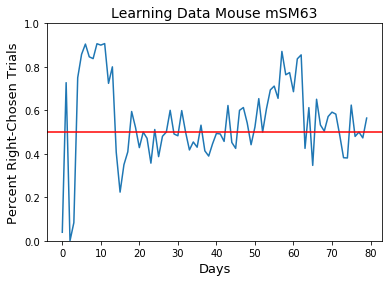

In [21]:
# Plots percent right
p_right_chosen = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_Vc=False
        )
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    incorrect_trials = np.argwhere(expected != actual)
    incorrect_responses = actual[incorrect_trials]
    p_right_chosen.append(
        np.sum(incorrect_responses == 2)*1.0/incorrect_responses.size
        )
fig, ax = plt.subplots()
ax.plot(p_right_chosen)
plt.ylabel("Percent Right-Chosen Trials", fontsize=13)
plt.xlabel("Days", fontsize=13)
plt.title("Learning Data Mouse mSM63", fontsize=14)
plt.ylim((0.0,1.0))
ax.axhline(0.5, color="red")
plt.show()

## Looking at Choice Decoding

In [11]:
all_results = pickle.load(
    open("pickles/choicedecodinglrshuffle_learning_mSM63.p", "rb")
    )

In [16]:
result.keys()

dict_keys(['scores', 'models', 'test_indices', 'correct_test_indices'])

In [ ]:
# Plots choice decoding, colored by time
import matplotlib.pylab as pl
plt.figure()
dates_of_interest = dates[:-10]
colors = pl.cm.Greys(np.linspace(-0.1,1.1,len(dates_of_interest)))
for idx, date in enumerate(dates_of_interest):
    result = all_results[idx]
    if result['models'] is None:
        continue
    num_test_trials = result['test_indices'][0].size
    min_num_trials = 200 # Test and train trials
    if num_test_trials < min_num_trials*0.2:
        continue
    plt.plot(result['scores'], color=colors[idx])
plt.ylim((0.5,1.0))
plt.title("Learning Data Neural Activity", fontsize=14)
plt.ylabel("Previous Stim Decoding", fontsize=13)
plt.xticks(
    [5,15],
    ['Stim On', 'Stim Off'],
    fontsize=13
    )
plt.show()

In [37]:
all_results[0].keys()

dict_keys(['scores', 'models', 'frame_indices', 'test_indices', 'correct_test_indices'])

In [14]:
# Look at test trials to examine why the choice decoding
# is so good in the beginning
dates_of_interest = dates[:-10]
p_corrects = []
for idx, date in enumerate(dates_of_interest):
    result = all_results[idx]
    num_test_trials = result['test_indices'][0].size
    min_num_trials = 200 # Test and train trials
    if num_test_trials < min_num_trials*0.2:
        continue
    session = LearningSession(
        animal, date, access_engram=True
        )
    predictor = SVCChoice(session)
    expected = np.array(session.trialmarkers['CorrectSide'])
    actual = np.array(session.trialmarkers['ResponseSide'])
    trial_index_map = predictor.get_trial_index_map()
    for i in range(10):
        test_indices = result['test_indices'][i]
        correct_test_indices = result['correct_test_indices'][i]
        correct_test_indices = correct_test_indices
        test_indices = test_indices[correct_test_indices]
        index_map = trial_index_map[i]
        true_test_indices = index_map[test_indices]
        correct = np.sum(
            expected[true_test_indices] == actual[true_test_indices]
            )
        p_correct = correct/(test_indices.size * 1.0)
        p_corrects.append(p_correct)

(array([  4.,  21.,  30.,  63.,  62.,  80.,  66.,  98., 126.,  60.]),
 array([0.48333333, 0.535     , 0.58666667, 0.63833333, 0.69      ,
        0.74166667, 0.79333333, 0.845     , 0.89666667, 0.94833333,
        1.        ]),
 <a list of 10 Patch objects>)

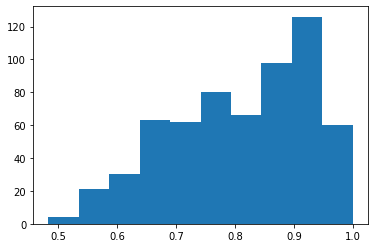

In [15]:
plt.hist(p_corrects)